In [1]:
from tools import utils, config, trainer, parts
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from tools import utils

plt.style.use('fast')
PLOT_DIR = 'plots'

cfg = config.from_yaml("experiments\exp2_net7_tiny\config.yaml")
dataset = utils.load_dataset_module(**cfg.data_supervised)
dataset.torch_seed()
test_loader = dataset.get_test_loader(**cfg.data_supervised)
test_dataset = dataset.get_test_dataset()

# Trained model
model = utils.load_model(**cfg.model)
model.load_state_dict(torch.load("experiments\exp2_net7_tiny\checkpoint.pth"))

part_manager = parts.PartManager(model)
part_manager.enable_all()

trn = trainer.ModelTrainer(model, cfg.trainer_sup, part_manager)

model.eval();

Loading dataset: data\mnist.py
Created 2 parts.
Enable all parts
checkpoint to cuda:0


### Get Adversarial Examples

In [2]:
from attack import do_attack
attack_examples = do_attack(model, trn.device, test_loader, fast = False)

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square


D:\Miniconda3\envs\env\lib\site-packages\torch\nn\modules\module.py:1102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


initial accuracy: 96.90%
apgd-ce - 1/39 - 19 out of 250 successfully perturbed
apgd-ce - 2/39 - 24 out of 250 successfully perturbed
apgd-ce - 3/39 - 26 out of 250 successfully perturbed
apgd-ce - 4/39 - 30 out of 250 successfully perturbed
apgd-ce - 5/39 - 36 out of 250 successfully perturbed
apgd-ce - 6/39 - 19 out of 250 successfully perturbed
apgd-ce - 7/39 - 24 out of 250 successfully perturbed
apgd-ce - 8/39 - 29 out of 250 successfully perturbed
apgd-ce - 9/39 - 18 out of 250 successfully perturbed
apgd-ce - 10/39 - 14 out of 250 successfully perturbed
apgd-ce - 11/39 - 23 out of 250 successfully perturbed
apgd-ce - 12/39 - 27 out of 250 successfully perturbed
apgd-ce - 13/39 - 18 out of 250 successfully perturbed
apgd-ce - 14/39 - 19 out of 250 successfully perturbed
apgd-ce - 15/39 - 23 out of 250 successfully perturbed
apgd-ce - 16/39 - 26 out of 250 successfully perturbed
apgd-ce - 17/39 - 33 out of 250 successfully perturbed
apgd-ce - 18/39 - 15 out of 250 successfully pert

### Get samples from each class

In [3]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_classes = len(classes)
class_size = 27
classes_to_accumulate = [c for c in classes]
examples = {i: [] for i in classes}
predictions = {c: [] for c in classes}

i = 0
while i < len(test_dataset):
    x, y = test_dataset[i]
    if not y in classes:
        i += 1
        continue
    
    if not y in classes_to_accumulate:
        i+=1
        continue
    
    x = attack_examples[i]
    x = x.unsqueeze(0).to(trn.device)
    y_pred = model(x)
    y_pred = np.argmax(y_pred.cpu().detach().numpy())
    
    if y_pred != y:
        examples[y].append(i)
        predictions[y].append(y_pred)
    if len(examples[y]) == class_size:
        classes_to_accumulate.remove(y)
        if len(classes_to_accumulate) == 0:
            break
    i+=1

In [4]:
print("Number of perturbed examples per class:")
[f'{k}:{len(v)}' for k, v in examples.items()]

Number of perturbed examples per class:


['0:27',
 '1:27',
 '2:27',
 '3:27',
 '4:27',
 '5:27',
 '6:27',
 '7:27',
 '8:27',
 '9:27']

### Get Outputs for Adversarial and Regular Examples

In [5]:
part_i = 0

part_output_list_adv = [[] for _ in range(n_classes)]
part_output_list = [[] for _ in range(n_classes)]

for class_i, class_examples in examples.items():
    class_order = classes.index(class_i)
    for example_i in class_examples:
        x, y = test_dataset[example_i]
        x = x.unsqueeze(0).to(trn.device)
        _ = model(x)
        
        part_output = getattr(part_manager.parts[part_i].get_loss_end_layer(), trainer.SAVED_OUTPUT_NAME)
        part_output = torch.squeeze(part_output).cpu().detach().numpy()
        part_output_list[class_order].append(part_output)
        
        x = attack_examples[example_i]
        x = x.unsqueeze(0).to(trn.device)
        _ = model(x)
        
        part_output = getattr(part_manager.parts[part_i].get_loss_end_layer(), trainer.SAVED_OUTPUT_NAME)
        part_output = torch.squeeze(part_output).cpu().detach().numpy()
        part_output_list_adv[class_order].append(part_output)
    
activations = np.array(part_output_list)
activations_adv = np.array(part_output_list_adv)

activations.shape # i_class, i_example, i_kernel, h, w

(10, 27, 20, 7, 7)

In [6]:
def get_flattened_activations(activations, class_i, channel_i):
    flat_size = class_size
    h = activations.shape[-2]

    flattened_kernel = np.zeros((h, flat_size * h))
    for example_i in range(activations.shape[1]):
        flattened_kernel[:, example_i * h: (example_i+1) * h] = activations[class_i, example_i, channel_i]
    return flattened_kernel

class_i = 0
channel_i = 0
flattened_activations = get_flattened_activations(activations, class_i, channel_i)
flattened_activations_adv = get_flattened_activations(activations_adv, class_i, channel_i)

### Flattened activations for a single kernel - Regular

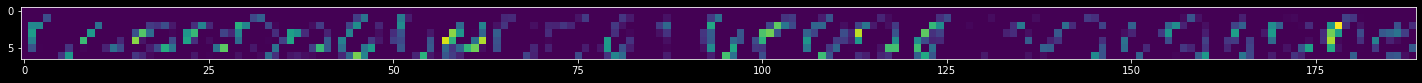

In [7]:
plt.figure(figsize=(25, 5))
plt.imshow(flattened_activations)

### Flattened activations for a single kernel - Adversarial

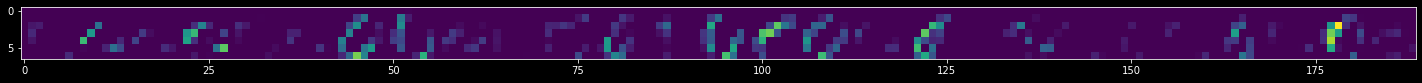

In [8]:
plt.figure(figsize=(25, 5))
plt.imshow(flattened_activations_adv)

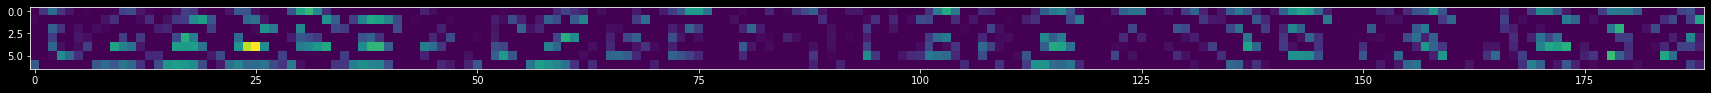

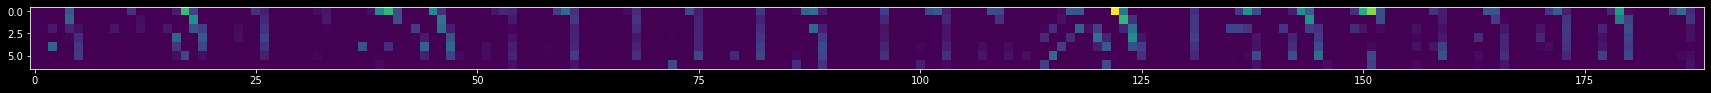

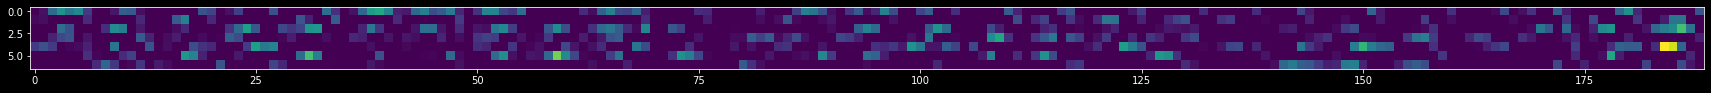

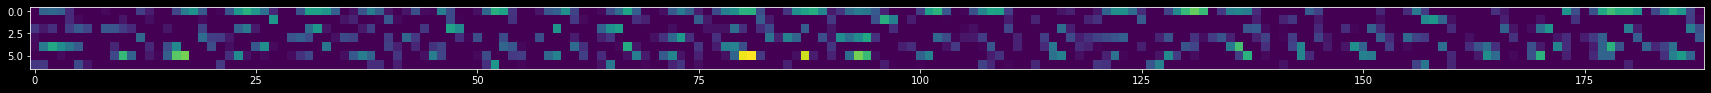

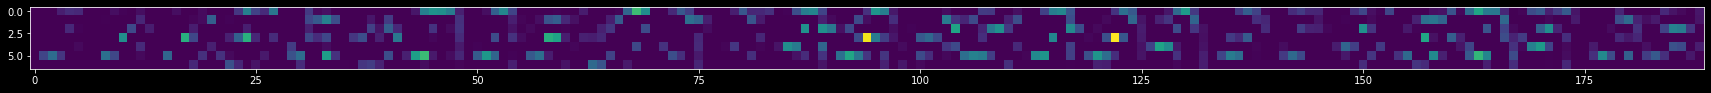

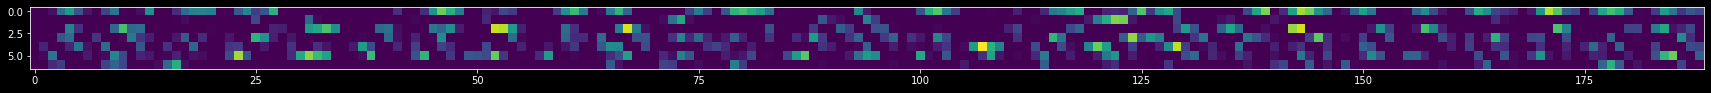

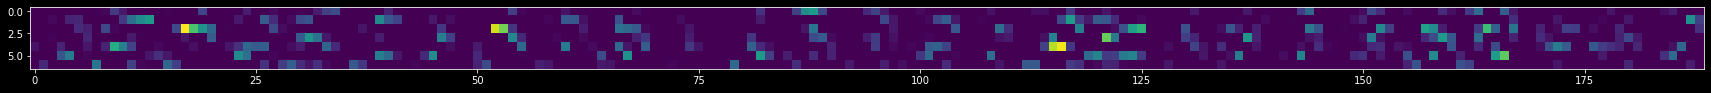

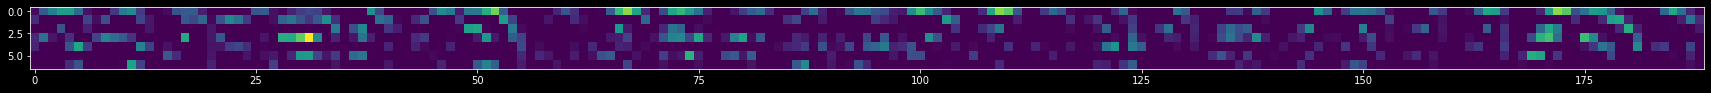

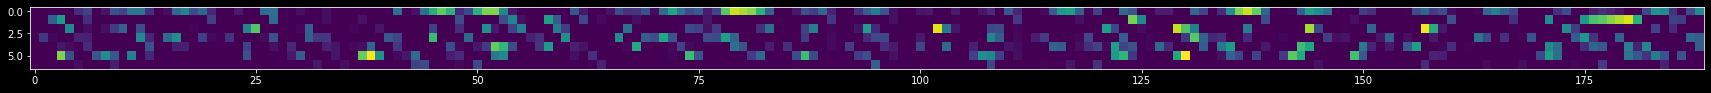

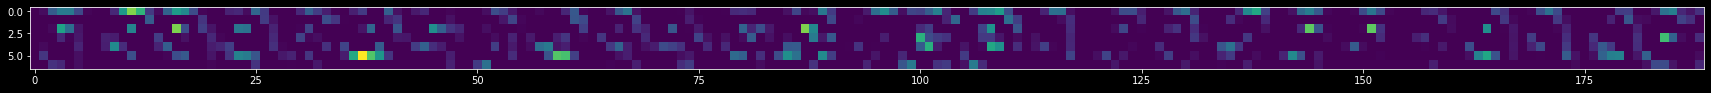

In [9]:
KERNEL_I = 1
for class_i in range(n_classes):
    plt.figure(figsize=(30, 3))
    flat_kernel = get_flattened_activations(activations, class_i, KERNEL_I)
    plt.imshow(flat_kernel)

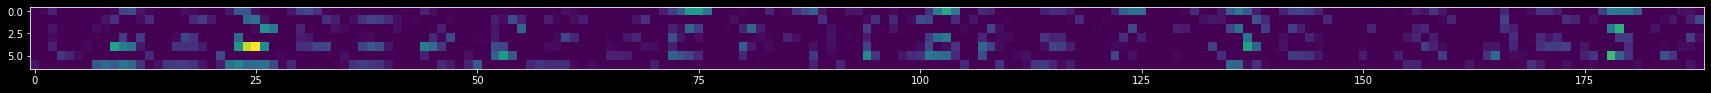

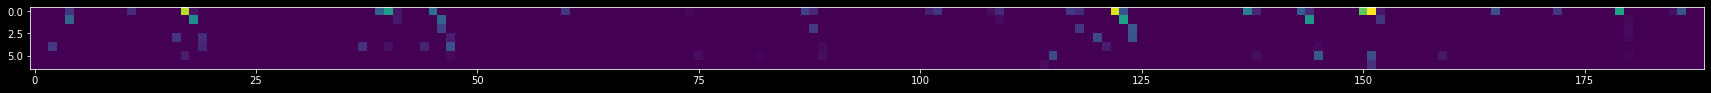

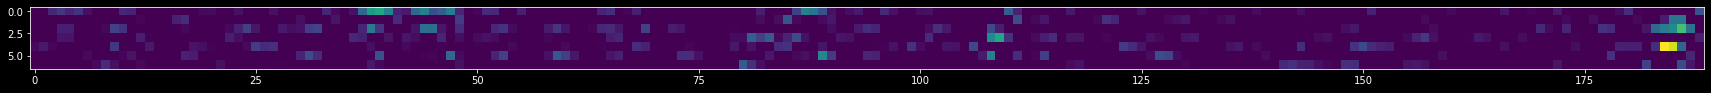

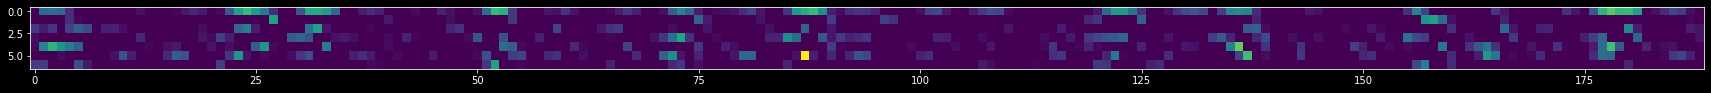

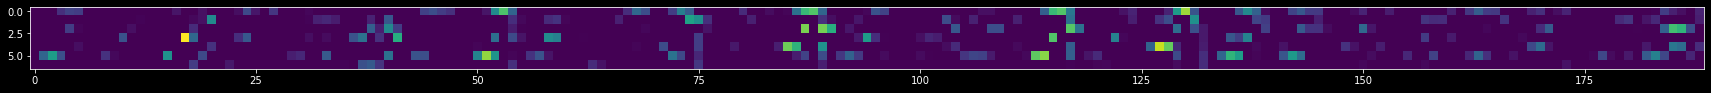

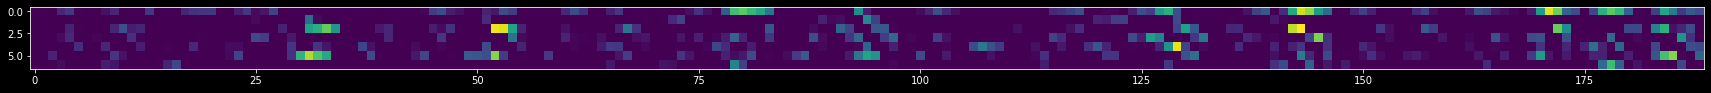

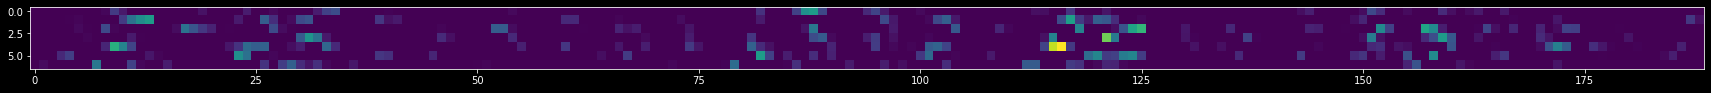

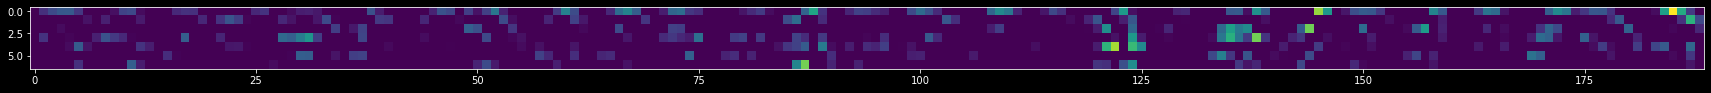

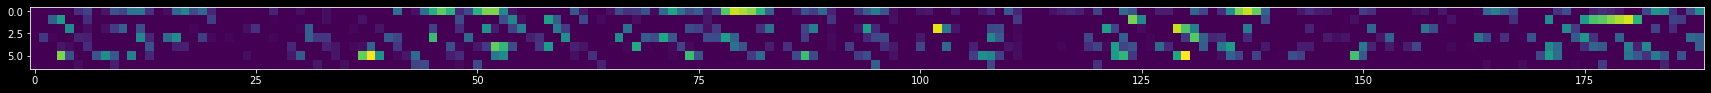

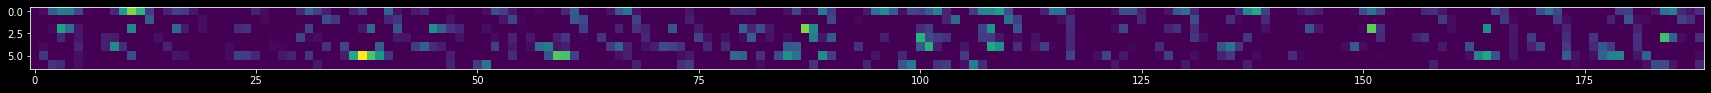

In [10]:
for class_i in range(n_classes):
    plt.figure(figsize=(30, 5))
    flat_kernel = get_flattened_activations(activations_adv, class_i, KERNEL_I)
    plt.imshow(flat_kernel)

In [11]:
activations_median = np.mean(activations, axis=1).reshape((10, -1))
activations_adv_median = np.mean(activations_adv, axis=1).reshape((10, -1))

activations_median_std = np.nan_to_num(activations_median.std(axis=0))
activations_adv_median_std = np.nan_to_num(activations_adv_median.std(axis=0), nan=1.0)
activations_median_std[activations_median_std==0] = 1.0
activations_adv_median_std[activations_adv_median_std==0] = 1.0

activations_median = (activations_median - activations_median.mean(axis=0)) / activations_median_std
activations_adv_median = (activations_adv_median - activations_adv_median.mean(axis=0)) / activations_adv_median_std

"""activations_median = np.nan_to_num(activations_median, nan=np.nanmin(activations_median))
activations_adv_median = np.nan_to_num(activations_adv_median, nan=np.nanmin(activations_adv_median))"""

'activations_median = np.nan_to_num(activations_median, nan=np.nanmin(activations_median))\nactivations_adv_median = np.nan_to_num(activations_adv_median, nan=np.nanmin(activations_adv_median))'

In [12]:
exclude_i = 8
activations_median_copy = activations_median.copy()
activations_median_copy[exclude_i] = 0
max_activations = np.max(activations_median_copy, axis=0)
activations_median_copy[exclude_i] = 999
min_activations = np.min(activations_median_copy, axis=0)

In [13]:
excluded_class_most_activated = activations_median[exclude_i] - max_activations > 0
excluded_class_least_activated = activations_median[exclude_i] - min_activations < 0
excluded_feature_selected = np.logical_or(excluded_class_most_activated, excluded_class_least_activated)
diff_order = np.argsort(activations_median[exclude_i])

print(f"Excluded class is least activated in these features: {excluded_class_least_activated.sum()}")
print(f"Excluded class is most activated in these features: {excluded_class_most_activated.sum()}")

Excluded class is least activated in these features: 33
Excluded class is most activated in these features: 75


Activations sorted by their values for y=8 on regular examples


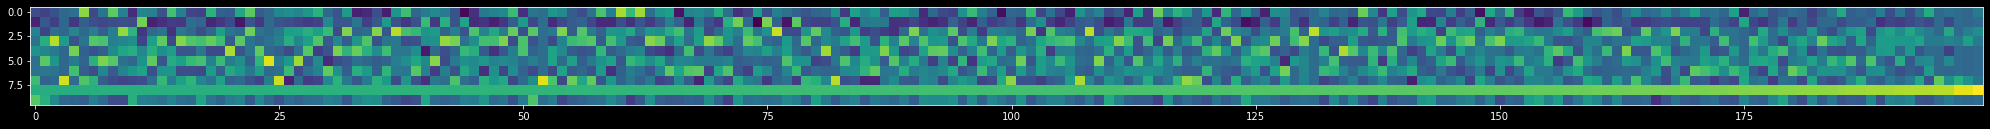

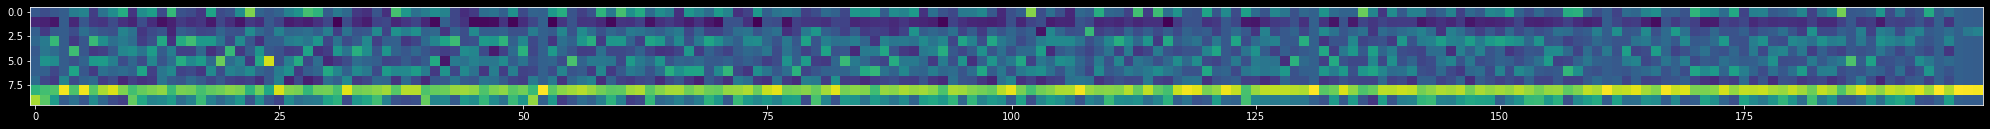

In [14]:
plt.figure(figsize=(35, 5))
plt.imshow(activations_median[:, diff_order][:, -200:])

plt.figure(figsize=(35, 5))
plt.imshow(activations_adv_median[:, diff_order][:, -200:])
print("Activations sorted by their values for y=8 on regular examples")

Activations where value for y=8 is the min or max among classes


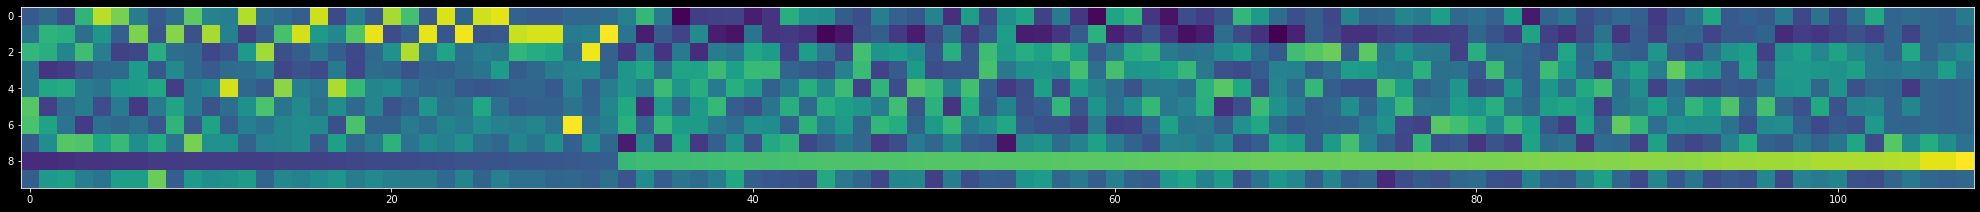

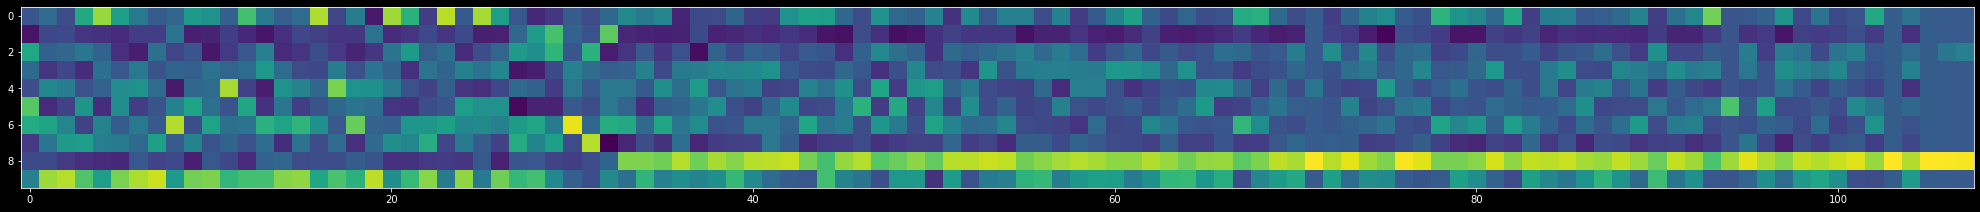

In [15]:
plt.figure(figsize=(35, 5))
act = activations_median[:, excluded_feature_selected]
act_order = np.argsort(act[exclude_i, :])
plt.imshow(act[:, act_order])

plt.figure(figsize=(35, 5))
act_adv = activations_adv_median[:, excluded_feature_selected]
plt.imshow(act_adv[: , act_order])
print("Activations where value for y=8 is the min or max among classes")

In [16]:
n_features = activations_median.shape[1]
robustness = np.zeros(n_features)
usefulness = np.zeros(n_features)
for i in range(n_features):
    usefulness[i] = (activations_median[:, i].max() - activations_median[:, i].mean()) / activations_median[:, i].std()
    robustness[i] = np.corrcoef(activations_median[:, i], activations_adv_median[:, i])[0, 1]
        
robustness = np.nan_to_num(robustness)
usefulness = np.nan_to_num(usefulness)

C:\Users\ozanz\AppData\Local\Temp/ipykernel_18640/3455174983.py:5: RuntimeWarning: invalid value encountered in float_scalars
  usefulness[i] = (activations_median[:, i].max() - activations_median[:, i].mean()) / activations_median[:, i].std()
D:\Miniconda3\envs\env\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Miniconda3\envs\env\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Features sorted by usefulness


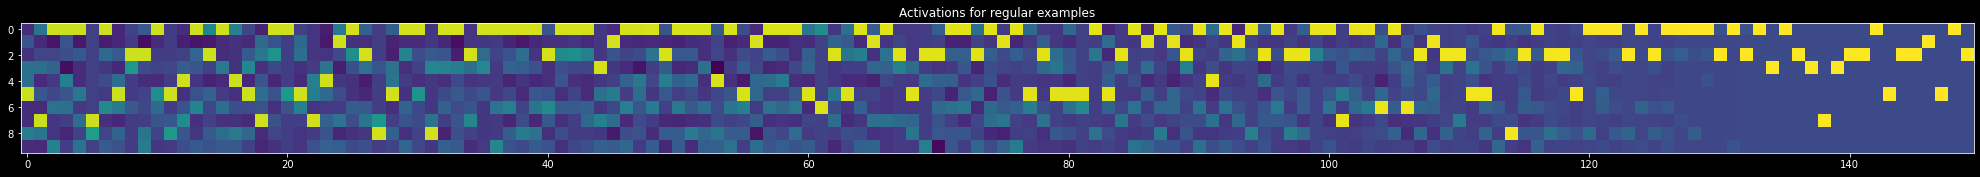

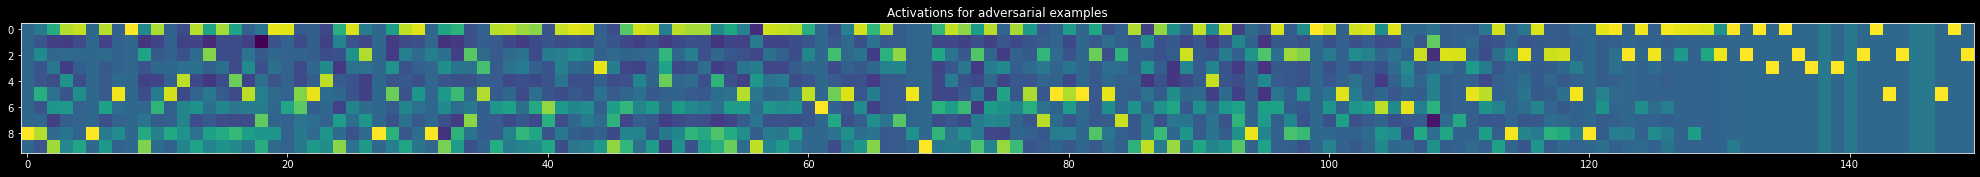

In [17]:
feature_order = np.argsort(usefulness)
plt.figure(figsize=(35, 7))
plt.imshow(activations_median[:, feature_order][:, -150:])
plt.title("Activations for regular examples")

plt.figure(figsize=(35, 7))
plt.imshow(activations_adv_median[:, feature_order][:, -150:])
plt.title("Activations for adversarial examples")
print("Features sorted by usefulness")

Features sorted by robustness
Top 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 0.9999999999999998, 0.9999999999999993, 0.9999740590330476, 0.9989402576134637, 0.9974176094238627, 0.9950585408540072, 0.9944580991897063, 0.9933472543119664, 0.992946566796684, 0.9927041171585453, 0.9910889327602985, 0.9909764799931029, 0.9904827021652156]
Bottom 25: [-0.40040469 -0.33266093 -0.26623876 -0.19215063 -0.13909324 -0.12407138
 -0.0841369  -0.07701343 -0.03112835 -0.02786094 -0.00578116  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


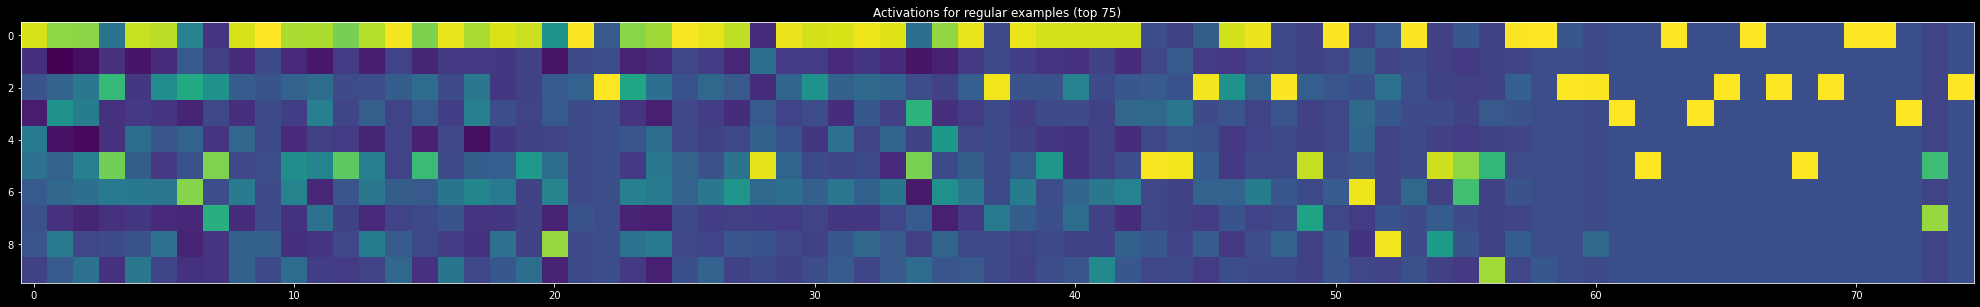

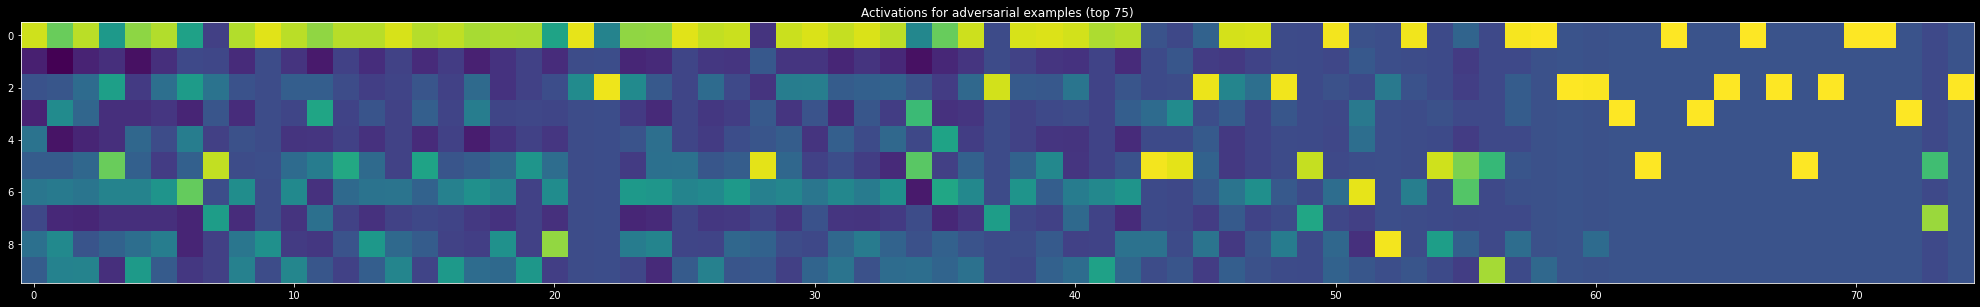

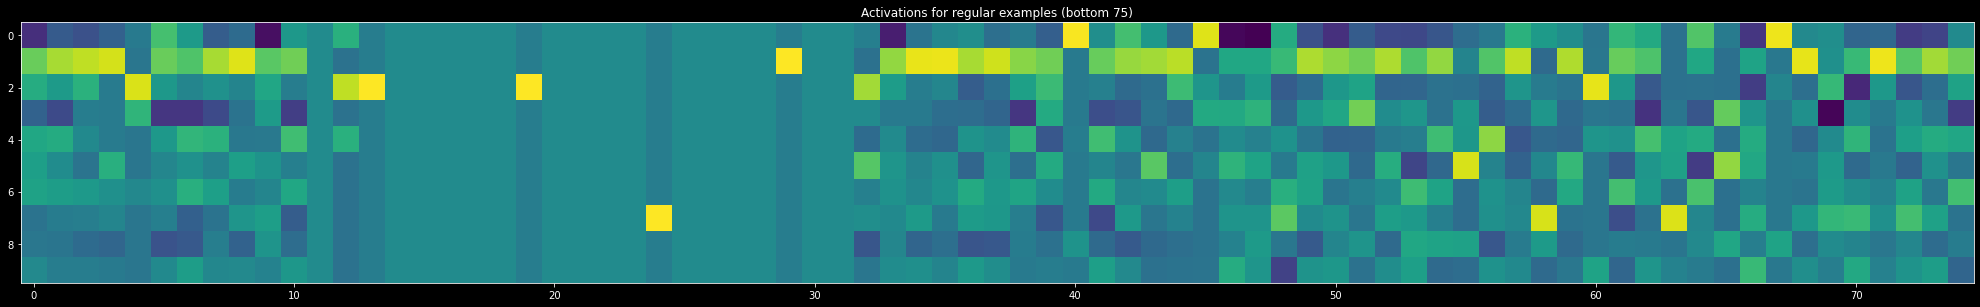

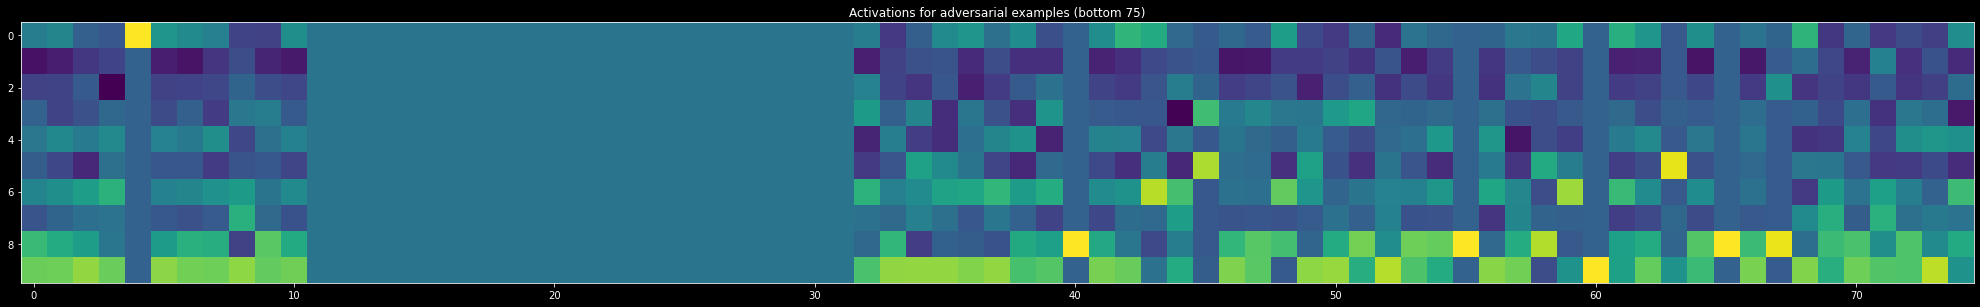

In [18]:
feature_order = np.argsort(robustness)
robustness_sorted = np.sort(robustness)
plt.figure(figsize=(35, 7))
plt.imshow(activations_median[:, feature_order][:, -75:])
plt.title("Activations for regular examples (top 75)")

plt.figure(figsize=(35, 7))
plt.imshow(activations_adv_median[:, feature_order][:, -75:])
plt.title("Activations for adversarial examples (top 75)")

plt.figure(figsize=(35, 7))
plt.imshow(activations_median[:, feature_order][:, :75])
plt.title("Activations for regular examples (bottom 75)")

plt.figure(figsize=(35, 7))
plt.imshow(activations_adv_median[:, feature_order][:, :75])
plt.title("Activations for adversarial examples (bottom 75)")
print("Features sorted by robustness")
print(f"Top 25: {list(reversed(robustness_sorted[-25:]))}")
print(f"Bottom 25: {robustness_sorted[:25]}")

Correlation: 0.2992596244286836


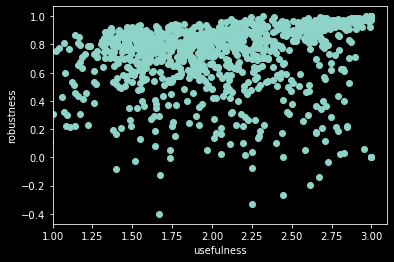

In [19]:
plt.scatter(usefulness, robustness)
plt.xlim([1.0, 3.1])
plt.xlabel("usefulness")
plt.ylabel("robustness")
print(f"Correlation: {np.corrcoef(usefulness, robustness)[1, 0]}")

### Robustness for kernels

In [20]:
kernel_robustness = robustness.reshape((20, 7, 7)).mean(axis=(1,2))
kernel_usefulness = usefulness.reshape((20, 7, 7)).mean(axis=(1,2))

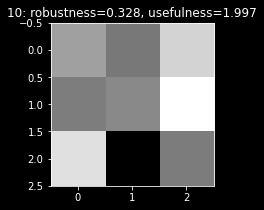

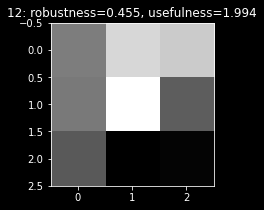

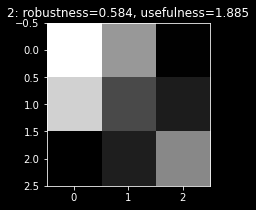

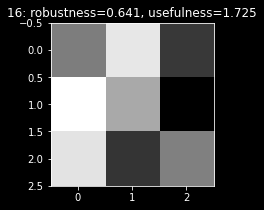

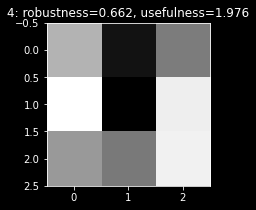

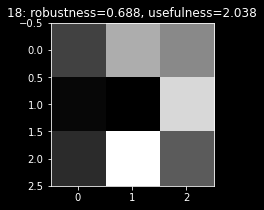

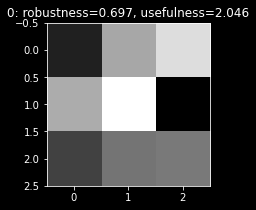

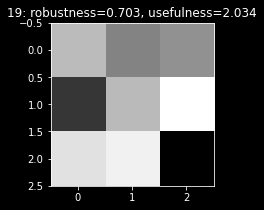

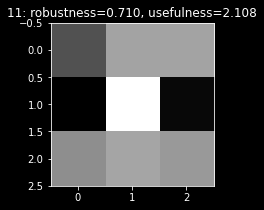

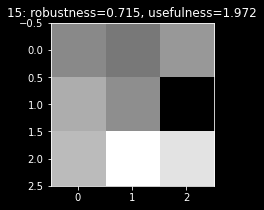

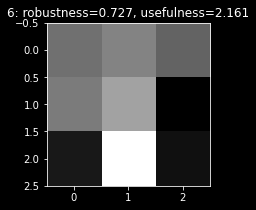

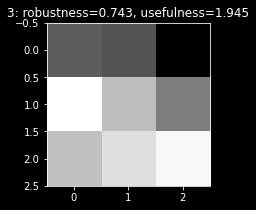

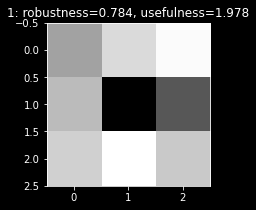

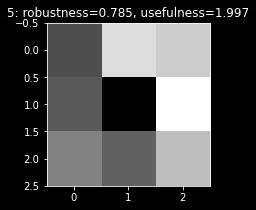

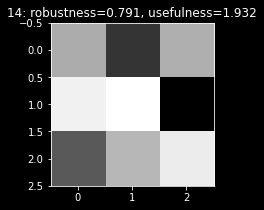

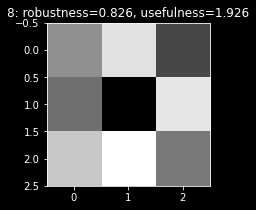

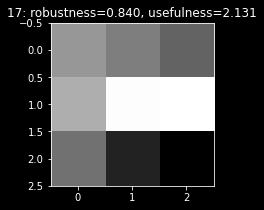

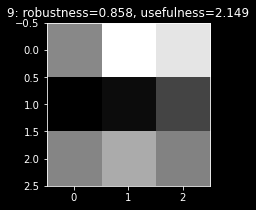

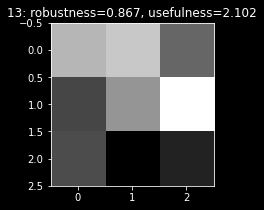

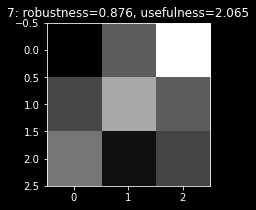

In [21]:
for i in np.argsort(kernel_robustness):
    plt.figure(figsize=(3, 3))
    plt.imshow(model.conv1.weight[i, 0].cpu().detach().numpy(), cmap="gray")
    plt.title(f"{i}: robustness={kernel_robustness[i]:.3f}, usefulness={kernel_usefulness[i]:.3f}")

Correlation: 0.32360428009101094


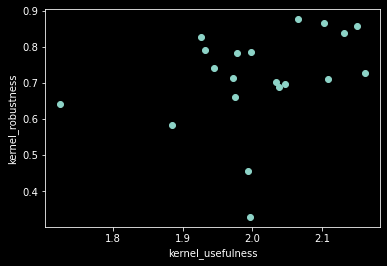

In [22]:
plt.scatter(kernel_usefulness, kernel_robustness)
plt.xlabel("kernel_usefulness")
plt.ylabel("kernel_robustness")
print(f"Correlation: {np.corrcoef(kernel_usefulness, kernel_robustness)[1, 0]}")

### Remove kernels

In [23]:
kernels_to_zero = np.argsort(kernel_robustness)[:2]
new_w = model.conv1.weight.clone()
new_b = model.conv1.bias.clone()

for i_kernel in kernels_to_zero:
    new_w[i_kernel] = 0.0
    new_b[i_kernel] = -100000.0

In [24]:
model.conv1.weight = torch.nn.Parameter(new_w)
model.conv1.bias = torch.nn.Parameter(new_b)
model.eval();

In [25]:
from attack import do_attack
attack_examples = do_attack(model, trn.device, test_loader, fast = False, first_n = 5000)

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square
initial accuracy: 94.28%
apgd-ce - 1/19 - 26 out of 250 successfully perturbed
apgd-ce - 2/19 - 30 out of 250 successfully perturbed
apgd-ce - 3/19 - 32 out of 250 successfully perturbed
apgd-ce - 4/19 - 35 out of 250 successfully perturbed
apgd-ce - 5/19 - 36 out of 250 successfully perturbed
apgd-ce - 6/19 - 18 out of 250 successfully perturbed
apgd-ce - 7/19 - 27 out of 250 successfully perturbed
apgd-ce - 8/19 - 31 out of 250 successfully perturbed
apgd-ce - 9/19 - 19 out of 250 successfully perturbed
apgd-ce - 10/19 - 27 out of 250 successfully perturbed
apgd-ce - 11/19 - 35 out of 250 successfully perturbed
apgd-ce - 12/19 - 31 out of 250 successfully perturbed
apgd-ce - 13/19 - 28 out of 250 successfully perturbed
apgd-ce - 14/19 - 24 out of 250 successfully perturbed
apgd-ce - 15/19 - 30 out of 250 successfully perturbed
apgd-ce - 16/19 - 35 out of 250 successfully perturbed


KeyboardInterrupt: 

### Remove features

In [ ]:
featrues_to_zero = np.argsort(usefulness)[:10]
feature_mask = np.ones(activations.shape[2] * activations.shape[3] * activations.shape[4])
feature_mask[featrues_to_zero] = 0.0

feature_mask = feature_mask.reshape((1, activations.shape[2], activations.shape[3], activations.shape[4]))
model.feature_gate = torch.nn.Parameter(torch.tensor(feature_mask, dtype=torch.float32).cuda())
model.eval();

In [ ]:
from attack import do_attack
attack_examples = do_attack(model, trn.device, test_loader, fast = False)